In [2]:
# Setup workspace 
import google.datalab.ml as ml
import json
import math
import matplotlib.pyplot as plot
import mltoolbox.regression.dnn as regression
import numpy as np
import pandas as pd
import os
import seaborn as sns
import sklearn.metrics as metrics

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# workspace_path = '/DataVisual/datalab/workspace/taxi'

In [1]:
# !mkdir -p {workspace_path}

In [3]:
import google.datalab.bigquery as bq

We started by examing the tlc_yellow_trips_2015 data on Google's BigQuery. This dataset has over 146 million records. We decided to only pull the month of July as our dataset which ended up being 6,775,789 records. The set included rate codes for standard fares, JKF and Newark. The JFK data was set fare that skewed our dataset so it was removed.

In [5]:
%%bq query --name taxi_sample
SELECT 
    EXTRACT(TIME FROM pickup_datetime) as tod,
    EXTRACT(DAYOFWEEK FROM pickup_datetime) as dow,
    pickup_datetime, 
    dropoff_datetime,
    rate_code,
    trip_distance, 
    fare_amount,
    extra,
    tip_amount,
    total_amount,
    ride_minutes

FROM 
`ucf-automate-nyc.cleaned.JULY_2015`
WHERE trip_distance > 0 AND fare_amount > 0 AND dropoff_datetime > pickup_datetime AND rate_code <> 2

In [6]:
taxi_query = taxi_sample.execute()
taxi_query.result()

tod,dow,pickup_datetime,dropoff_datetime,rate_code,trip_distance,fare_amount,extra,tip_amount,total_amount,ride_minutes
18:39:06,6,2015-07-03 18:39:06,2015-07-03 18:44:31,1,1.1,5.5,0.0,1.57,7.87,5
22:35:44,2,2015-07-20 22:35:44,2015-07-20 22:48:08,1,3.0,12.0,0.5,1.0,14.3,12
18:51:21,5,2015-07-16 18:51:21,2015-07-16 18:54:40,1,0.62,4.5,1.0,1.26,7.56,3
00:45:22,7,2015-07-18 00:45:22,2015-07-18 00:56:57,1,1.7,9.5,0.5,2.15,12.95,11
11:33:07,5,2015-07-16 11:33:07,2015-07-16 11:43:03,1,1.13,8.0,0.0,1.76,10.56,9
21:34:17,7,2015-07-25 21:34:17,2015-07-25 21:38:30,1,0.9,5.0,0.5,1.25,7.55,4
14:14:43,5,2015-07-23 14:14:43,2015-07-23 14:39:22,1,1.26,15.0,0.0,3.16,18.96,24
21:04:52,4,2015-07-29 21:04:52,2015-07-29 21:26:11,1,3.8,16.0,0.5,3.46,20.76,21
21:02:59,5,2015-07-09 21:02:59,2015-07-09 21:19:30,1,3.57,14.0,0.5,1.0,16.3,16
12:05:31,6,2015-07-17 12:05:31,2015-07-17 12:38:26,1,11.3,36.0,0.0,55.0,97.34,32


In [7]:
# Query results were saved to dataframe
taxi_df = taxi_query.result().to_dataframe()
taxi_df.head()

,tod,dow,pickup_datetime,dropoff_datetime,rate_code,trip_distance,fare_amount,extra,tip_amount,total_amount,ride_minutes
0,18:39:06,6,2015-07-03 18:39:06,2015-07-03 18:44:31,1,1.10,5.5,0.0,1.57,7.87,5
1,22:35:44,2,2015-07-20 22:35:44,2015-07-20 22:48:08,1,3.00,12.0,0.5,1.00,14.30,12
2,18:51:21,5,2015-07-16 18:51:21,2015-07-16 18:54:40,1,0.62,4.5,1.0,1.26,7.56,3
3,00:45:22,7,2015-07-18 00:45:22,2015-07-18 00:56:57,1,1.70,9.5,0.5,2.15,12.95,11
4,11:33:07,5,2015-07-16 11:33:07,2015-07-16 11:43:03,1,1.13,8.0,0.0,1.76,10.56,9


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


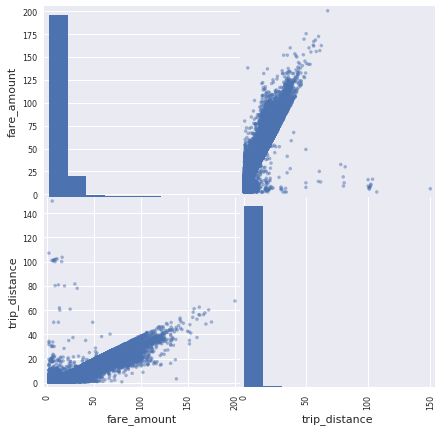

In [8]:
#Visualize dataset
%matplotlib inline
pd.plotting.scatter_matrix(frame = taxi_df[['fare_amount', 'trip_distance']], figsize=(7,7));

For better scale, we further filtered dataset for fares between $3 and 100 and trips between 2 and 25 miles

In [9]:
taxi_df_filtered = taxi_df[(taxi_df['fare_amount'] >= 3) & (taxi_df['fare_amount'] <=100)& 
                           (taxi_df['trip_distance'] >=2) & (taxi_df['trip_distance'] <= 25)]

Our visualization does show correlation between trip distance and trip fare as we expected. 

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


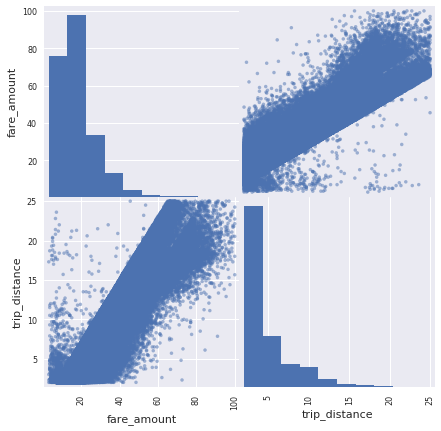

In [10]:
pd.plotting.scatter_matrix(frame = taxi_df_filtered[['fare_amount', 'trip_distance']], figsize=(7,7));

In [11]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [12]:
#Assign data to X and y
#Need to use reshape to create two-d array of values
X=taxi_df_filtered['trip_distance'].values.reshape(-1,1)
y=taxi_df_filtered['fare_amount'].values.reshape(-1,1)
print("Shape: ", X.shape, y.shape)

Shape:  (3202563, 1) (3202563, 1)


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


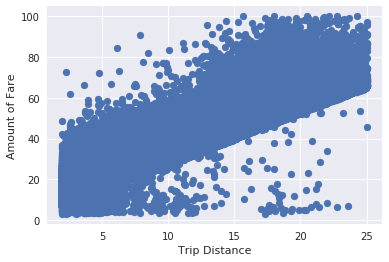

In [13]:
#Plot the data to see if a linear trend exits
plot.scatter(X,y)
plot.xlabel("Trip Distance")
plot.ylabel("Amount of Fare")
plot.savefig("DistFare.png")
plot.show()

In [14]:
#use train_test_split to create training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [15]:
model = LinearRegression()

In [16]:
# Fit the model to the training data and calculate the scores for the training and testing data
model.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
print ('Weight coeff: %.3f' % model.coef_)
print ('y-axis intercept: %.3f' % model.intercept_)       

Weight coeff: 2.723
y-axis intercept: 5.220


In [18]:
#Calculate the MSE and r2 for testing data
#Use our model to make predictions
predicted = model.predict(X_test)

# x_min = X.min()
# x_max = X.max()
# print('Min X Value: %.3f' % x_min)
# print('Max X Value: %.3f' % x_max)

print ('True output: %.3f' % y[0])
print ('Predicted output: %.3f' % predicted[0])
print ('Predicted error: %.3f' % (predicted[0]-y[0]))

True output: 12.000
Predicted output: 10.666
Predicted error: -1.334


In [19]:
#Score the predictions with mse and r2
mse=mean_squared_error(y_test, predicted)
r2=r2_score(y_test, predicted)

print ('Mean Squared Error: %.3f' % mse)
print ('R-squared (r2): %.3f' % r2)

Mean Squared Error: 8.819
R-squared (r2): 0.894


In [20]:
# Call the score method on the model to show the r2 score

testing_score = model.score(X_test, y_test)

print('Testing Score: %.3f' % testing_score)

Testing Score: 0.894


In [21]:
# LASSO model
# use an alpha of .01 when creating model
from sklearn.linear_model import Lasso

In [22]:
lasso=Lasso(alpha=.01).fit(X_train, y_train)
prediction1 = lasso.predict(X_test)

l_mse = mean_squared_error(y_test, prediction1)
l_r2 = lasso.score(X_test, y_test)

print ('Means Squared Error: %.3f' % l_mse)
print ('R-squared (r2): %.3f' % l_r2)

Means Squared Error: 8.819
R-squared (r2): 0.894


In [23]:
# RandomForestRegressor model
#
regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train.ravel())
y_pred = regressor.predict(X_test)

In [24]:
rf_mse = mean_squared_error(y_test, y_pred)
rf_r2 = regressor.score(X_test, y_test)

print('Mean Square Error: %.3f' % rf_mse)
print('R-squared (r2): %.3f' % rf_r2)

Mean Square Error: 8.690
R-squared (r2): 0.896


Conclusion: As expected fare_amounts are correlated with trip_distance. Our predicted output is $10.66.  We used three models namely; linear regression, LASSO and RandomForest.  All models produced very similar results.  Based on our set our models did well with MSE of 8.819 and r2 of .894 for both the linear regression and Lasso models.  The RandomForest model gave use MSE of 8.69 and r2 of .896.   